In [1]:
import os
import pandas as  pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

## Dataset

In [2]:
class NUSW_NB15_Dataset(Dataset):
    def __init__(self, path):
        ds_type = path.split('/')[-1].split('-')[0]
        df = pd.read_csv(path)
        
        x = df.drop(['id', 'attack_cat', 'label'], axis=1)
        y = df['label']

        self.x = torch.Tensor(x.to_numpy())
        self.y = torch.Tensor(y)

        self.dim = self.x.shape[1]

        print(
            f'Finished reading the {ds_type} set of Dataset '\
            f'({len(self.x)} samples found, each dim = {self.dim})'
        )

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)
    

def prep_dataloader(path, batch_size, shuffle):
    dataset = NUSW_NB15_Dataset(path)
    dataloader = DataLoader(
        dataset,
        batch_size,
        shuffle
    )
    return dataloader

## Neural Network

In [3]:
class BC(nn.Module):
    def __init__(self):
        super(BC, self).__init__()
        self.linear_elu_stack = nn.Sequential(
            nn.Linear(196, 256),
            nn.ELU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ELU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 16),
            nn.ELU(),
            nn.BatchNorm1d(16),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.linear_elu_stack(x)
        return x

## Trainer

In [4]:
def train(dataloader, model, loss_fn, optimizer, device):
    num_batches = len(dataloader)
    avg_loss = 0
    model.train()
    with tqdm(dataloader) as pbar:
        for (X, y) in pbar:
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y.unsqueeze(1))

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # sum loss and correct
            avg_loss += loss.item()

            # set loss val to pbar
            pbar.set_postfix(loss=f'{loss.item():>7f}')

    # cal avg loss and correct
    avg_loss /= num_batches
    print(f"[Train] Avg loss: {avg_loss:>8f} \n")
    return avg_loss


def test(dataloader, model, loss_fn, device):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y.unsqueeze(1)).item()
    test_loss /= num_batches
    print(f"[Test] Avg loss: {test_loss:>8f} \n")
    return test_loss

## Training & Testing

### Set Config

In [5]:
# config
# path
tr_path = '../../data/anomaly_detection/training-set.csv'
val_path = '../../data/anomaly_detection/validation-set.csv'
tt_path = '../../data/anomaly_detection/testing-set.csv'
log_path = '../../logs/anomaly_detection'
model_path = '../../models/anomaly_detection/BC_model_weights.pth'

# hyperparameter
epochs = 60
batch_size = 64
lr = 1e-3

### Load Data

In [6]:
# prepare dataloader
tr_dl = prep_dataloader(
    tr_path,
    batch_size,
    shuffle=True
)

val_dl = prep_dataloader(
    val_path,
    batch_size,
    shuffle=True
)

tt_dl = prep_dataloader(
    tt_path,
    batch_size,
    shuffle=False
)

Finished reading the training set of Dataset (164910 samples found, each dim = 196)
Finished reading the validation set of Dataset (41228 samples found, each dim = 196)
Finished reading the testing set of Dataset (51535 samples found, each dim = 196)


### Training 

In [7]:
def get_log_name(model, loss_fn, optimizer, epochs, batch_size, lr):
    m = model.__class__.__name__
    l_fn = loss_fn.__class__.__name__
    opt = optimizer.__class__.__name__

    dt = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    return f'{m}_ep-{epochs}_bs-{batch_size}_lr-{lr}_l-fn-{l_fn}_opt-{opt}_{dt}'

In [8]:
# training and validation
# device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# neural network
model = BC().to(device)

# loss func and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

# load model weight
if os.path.isfile(model_path):
    print(f'Load model weights form {model_path}')
    model.load_state_dict(torch.load(model_path))

# summary writer
last_log_path = os.path.join(
    log_path, get_log_name(model, loss_fn, optimizer, epochs, batch_size, lr)
)
writer = SummaryWriter(last_log_path)

# training and validation
min_loss = 1000
for t in range(epochs):
    ep = t + 1
    print(f"Epoch {ep}")
    tr_loss = train(tr_dl, model, loss_fn, optimizer, device)
    val_loss = test(val_dl, model, loss_fn, device)
    
    # log loss and acc
    writer.add_scalar('Loss/train', tr_loss, ep)
    writer.add_scalar('Loss/val', val_loss, ep)
    
    # save best model by min val loss
    if val_loss < min_loss:
        print(f'Saving model to {model_path}\n')
        torch.save(model.state_dict(), model_path)
        min_loss = val_loss

print("Done!")

Using cuda device
Epoch 1


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.177803 

[Test] Avg loss: 0.157159 

Saving model to ../../models/anomaly_detection/BC_model_weights.pth

Epoch 2


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.153198 

[Test] Avg loss: 0.145411 

Saving model to ../../models/anomaly_detection/BC_model_weights.pth

Epoch 3


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.146438 

[Test] Avg loss: 0.140205 

Saving model to ../../models/anomaly_detection/BC_model_weights.pth

Epoch 4


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.142152 

[Test] Avg loss: 0.140564 

Epoch 5


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.138739 

[Test] Avg loss: 0.134420 

Saving model to ../../models/anomaly_detection/BC_model_weights.pth

Epoch 6


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.136164 

[Test] Avg loss: 0.133755 

Saving model to ../../models/anomaly_detection/BC_model_weights.pth

Epoch 7


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.134779 

[Test] Avg loss: 0.132677 

Saving model to ../../models/anomaly_detection/BC_model_weights.pth

Epoch 8


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.133480 

[Test] Avg loss: 0.134555 

Epoch 9


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.132459 

[Test] Avg loss: 0.130560 

Saving model to ../../models/anomaly_detection/BC_model_weights.pth

Epoch 10


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.131399 

[Test] Avg loss: 0.131477 

Epoch 11


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.130164 

[Test] Avg loss: 0.131576 

Epoch 12


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.129346 

[Test] Avg loss: 0.127256 

Saving model to ../../models/anomaly_detection/BC_model_weights.pth

Epoch 13


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.128511 

[Test] Avg loss: 0.128072 

Epoch 14


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.127813 

[Test] Avg loss: 0.132019 

Epoch 15


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.127635 

[Test] Avg loss: 0.129114 

Epoch 16


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.126750 

[Test] Avg loss: 0.126498 

Saving model to ../../models/anomaly_detection/BC_model_weights.pth

Epoch 17


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.126257 

[Test] Avg loss: 0.130363 

Epoch 18


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.125651 

[Test] Avg loss: 0.128592 

Epoch 19


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.125267 

[Test] Avg loss: 0.127542 

Epoch 20


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.125191 

[Test] Avg loss: 0.125952 

Saving model to ../../models/anomaly_detection/BC_model_weights.pth

Epoch 21


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.124291 

[Test] Avg loss: 0.134149 

Epoch 22


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.124163 

[Test] Avg loss: 0.125087 

Saving model to ../../models/anomaly_detection/BC_model_weights.pth

Epoch 23


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.123582 

[Test] Avg loss: 0.127456 

Epoch 24


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.123424 

[Test] Avg loss: 0.125662 

Epoch 25


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.122766 

[Test] Avg loss: 0.130932 

Epoch 26


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.122487 

[Test] Avg loss: 0.125882 

Epoch 27


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.122217 

[Test] Avg loss: 0.123981 

Saving model to ../../models/anomaly_detection/BC_model_weights.pth

Epoch 28


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.121549 

[Test] Avg loss: 0.126879 

Epoch 29


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.121708 

[Test] Avg loss: 0.125753 

Epoch 30


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.121183 

[Test] Avg loss: 0.124957 

Epoch 31


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.120680 

[Test] Avg loss: 0.127875 

Epoch 32


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.120330 

[Test] Avg loss: 0.125636 

Epoch 33


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.120170 

[Test] Avg loss: 0.126751 

Epoch 34


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.120092 

[Test] Avg loss: 0.125994 

Epoch 35


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.119546 

[Test] Avg loss: 0.123771 

Saving model to ../../models/anomaly_detection/BC_model_weights.pth

Epoch 36


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.119189 

[Test] Avg loss: 0.124924 

Epoch 37


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.119179 

[Test] Avg loss: 0.125923 

Epoch 38


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.118542 

[Test] Avg loss: 0.126725 

Epoch 39


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.118172 

[Test] Avg loss: 0.124493 

Epoch 40


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.118102 

[Test] Avg loss: 0.125995 

Epoch 41


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.118036 

[Test] Avg loss: 0.124168 

Epoch 42


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.117533 

[Test] Avg loss: 0.124693 

Epoch 43


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.117341 

[Test] Avg loss: 0.124883 

Epoch 44


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.117401 

[Test] Avg loss: 0.130304 

Epoch 45


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.117118 

[Test] Avg loss: 0.125081 

Epoch 46


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.116826 

[Test] Avg loss: 0.125292 

Epoch 47


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.116489 

[Test] Avg loss: 0.123042 

Saving model to ../../models/anomaly_detection/BC_model_weights.pth

Epoch 48


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.116312 

[Test] Avg loss: 0.124096 

Epoch 49


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.115941 

[Test] Avg loss: 0.124430 

Epoch 50


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.115801 

[Test] Avg loss: 0.124033 

Epoch 51


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.115658 

[Test] Avg loss: 0.122211 

Saving model to ../../models/anomaly_detection/BC_model_weights.pth

Epoch 52


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.115491 

[Test] Avg loss: 0.127888 

Epoch 53


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.114820 

[Test] Avg loss: 0.122534 

Epoch 54


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.115002 

[Test] Avg loss: 0.123078 

Epoch 55


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.114898 

[Test] Avg loss: 0.121710 

Saving model to ../../models/anomaly_detection/BC_model_weights.pth

Epoch 56


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.114373 

[Test] Avg loss: 0.123339 

Epoch 57


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.114288 

[Test] Avg loss: 0.124356 

Epoch 58


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.114138 

[Test] Avg loss: 0.121602 

Saving model to ../../models/anomaly_detection/BC_model_weights.pth

Epoch 59


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.113716 

[Test] Avg loss: 0.124324 

Epoch 60


  0%|          | 0/2577 [00:00<?, ?it/s]

[Train] Avg loss: 0.113585 

[Test] Avg loss: 0.125730 

Done!


### Testing

In [9]:
# testing
tt_loss = test(tt_dl, model, loss_fn, device)
writer.add_scalar('Loss/test', tt_loss, 1)

[Test] Avg loss: 0.124785 



## Evaluation

In [10]:
def create_predict_label_df(model, dl, device):
    preds = []
    labels = []
    model.eval()
    with torch.no_grad():
        for x, y in dl:
            pred = torch.round(model(x.to(device)).cpu()).numpy()
            preds.extend(pred.squeeze())
            labels.extend(y.numpy().astype(np.int8))

    return pd.DataFrame({'predict': preds, 'label': labels})


def predict(losses, threshold):
    return list(map(lambda loss: 1 if loss > threshold else 0, losses))


def show_confusion_matrix(label, pred):
    conf_matrix = confusion_matrix(label, pred)
    sns.set(font_scale=1.2)
    plt.figure(figsize=(10, 10))
    sns.heatmap(conf_matrix,
                xticklabels=['Not Attack', 'Attack'],
                yticklabels=['Not Attack', 'Attack'],
                annot=True,
                fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

In [11]:
# device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# neural network
model = BC().to(device)

# load model weight
print(f'Load model weights form {model_path}')
model.load_state_dict(torch.load(model_path))

Using cuda device
Load model weights form ../../models/anomaly_detection/BC_model_weights.pth


<All keys matched successfully>

In [12]:
tr_df = create_predict_label_df(model, tr_dl, device)
val_df = create_predict_label_df(model, val_dl, device)
tt_df = create_predict_label_df(model, tt_dl, device)

print('training dataset\n')
print(classification_report(tr_df['label'].values, tr_df['predict'].values))

print('validation dataset\n')
print(classification_report(val_df['label'].values, val_df['predict'].values))

print('testing dataset\n')
print(classification_report(tt_df['label'].values, tt_df['predict'].values))

training dataset

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     59584
           1       0.96      0.95      0.96    105326

    accuracy                           0.95    164910
   macro avg       0.94      0.94      0.94    164910
weighted avg       0.95      0.95      0.95    164910

validation dataset

              precision    recall  f1-score   support

           0       0.90      0.93      0.92     14753
           1       0.96      0.94      0.95     26475

    accuracy                           0.94     41228
   macro avg       0.93      0.94      0.94     41228
weighted avg       0.94      0.94      0.94     41228

testing dataset

              precision    recall  f1-score   support

           0       0.91      0.93      0.92     18663
           1       0.96      0.95      0.95     32872

    accuracy                           0.94     51535
   macro avg       0.93      0.94      0.93     51535
weighted avg       

training dataset



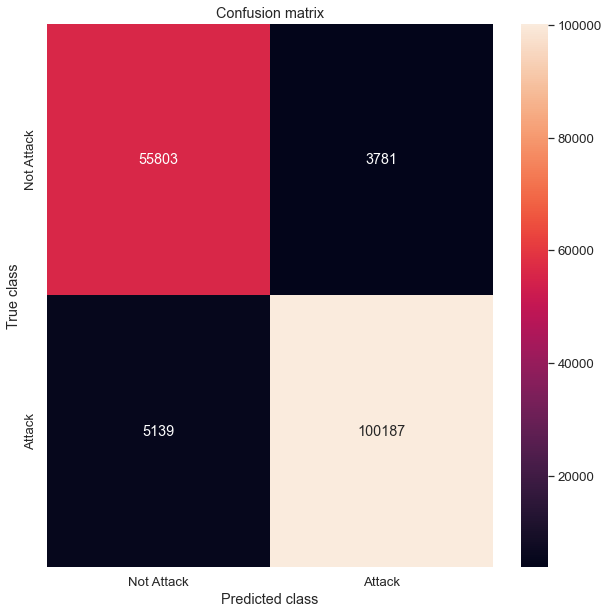

validation dataset



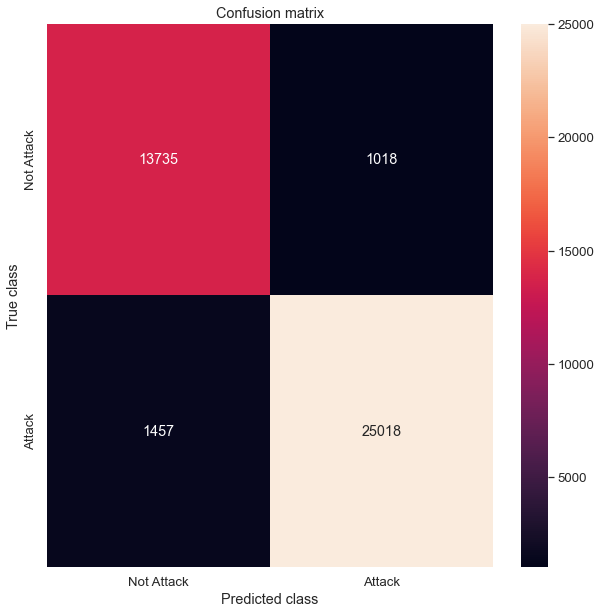

testing dataset



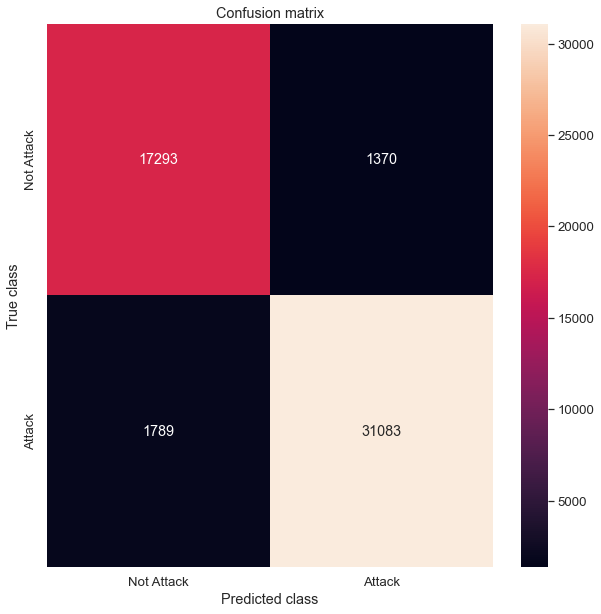

In [13]:
print('training dataset\n')
show_confusion_matrix(tr_df['label'].values, tr_df['predict'].values)
print('validation dataset\n')
show_confusion_matrix(val_df['label'].values, val_df['predict'].values)
print('testing dataset\n')
show_confusion_matrix(tt_df['label'].values, tt_df['predict'].values)